Автор: Лейман М.А.   
Дата создания: 22.03.2025  

# Задание ZALA  







## 1. Обработка датасета UAVOD

### Классы датасета  
'building': 0,      		здание  
'cable-tower': 1, 		кабельная вышка  
'cultivation-mesh-cage': 2,  	сетка для выращивания  
'landslide': 3, 		оползень  
'pool': 4, 			бассейн  
'prefabricated-house': 5, 	сборный-дом"  
'quarry': 6,			карьер  
'ship': 7, 			корабль  
'vehicle': 8,			транспортное средство  
'well': 9			колодец  



In [12]:
# Названия классов
class_names = ["building", "cultivation-mesh-cage", "landslide",
               "pool", "prefabricated-house", "quarry", "ship", "vehicle", "well"]


class_names2 = ["здание", "сетка для выращивания", "оползень",
               "бассейн", "сборный-дом", "карьер", "корабль", "транспортное средство", "колодец"]

## Преобразование датасета в формат YOLO

In [13]:
import os
import xml.etree.ElementTree as ET

# Получаем текущую рабочую папку  
current_directory = os.getcwd()  

path_dataset = os.path.join(current_directory, "dataset")

target_original = 'dataset_UAVOD/datasets_original/target/'    # таргеты XML
xml_dir = os.path.join(path_dataset, target_original)  

image_original = 'dataset_UAVOD/datasets_original/image/'    # Исходные изображения
image_dir = os.path.join(path_dataset, image_original)  

target_yolo_original = 'dataset_UAVOD/datasets_original/target_yolo/'    # YOLO разметка
output_txt_dir = os.path.join(path_dataset, target_yolo_original) 

print("Текущая папка:", current_directory)  
print("Датасет:      ", path_dataset)  
print("Таргет:       ", xml_dir)  
print("Изображения:  ", image_dir)  
print("Таргет YOLO:  ", output_txt_dir)  



Текущая папка: /home/maksim/develops/python/devsTraining/zala_task
Датасет:       /home/maksim/develops/python/devsTraining/zala_task/dataset
Таргет:        /home/maksim/develops/python/devsTraining/zala_task/dataset/dataset_UAVOD/datasets_original/target/
Изображения:   /home/maksim/develops/python/devsTraining/zala_task/dataset/dataset_UAVOD/datasets_original/image/
Таргет YOLO:   /home/maksim/develops/python/devsTraining/zala_task/dataset/dataset_UAVOD/datasets_original/target_yolo/


In [ ]:
os.makedirs(output_txt_dir, exist_ok=True)

def convert_voc_to_yolo(xml_file, output_dir):
    """ 
        Конвертирует датасет в YOLO формат
    """
    tree = ET.parse(xml_file)
    root = tree.getroot()

    # Получаем размеры изображения
    size = root.find("size")
    width = int(size.find("width").text)
    height = int(size.find("height").text)

    yolo_labels = []
    for obj in root.findall("object"):
        class_name = obj.find("name").text
        if class_name not in class_names:
            continue
        class_id = class_names.index(class_name)

        bbox = obj.find("bndbox")
        xmin, ymin, xmax, ymax = map(int, [bbox.find("xmin").text, bbox.find("ymin").text,
                                           bbox.find("xmax").text, bbox.find("ymax").text])

        # Перевод координат в нормализованные
        x_center = (xmin + xmax) / (2 * width)
        y_center = (ymin + ymax) / (2 * height)
        bbox_width = (xmax - xmin) / width
        bbox_height = (ymax - ymin) / height

        yolo_labels.append(f"{class_id} {x_center} {y_center} {bbox_width} {bbox_height}")

    # Сохранение  в файл
    filename = os.path.basename(xml_file).replace(".xml", ".txt")
    with open(os.path.join(output_dir, filename), "w") as f:
        f.write("\n".join(yolo_labels))

def convert_annotation():
    # Обрабатываем все XML
    for xml_file in os.listdir(xml_dir):
        if xml_file.endswith(".xml"):
            convert_voc_to_yolo(os.path.join(xml_dir, xml_file), output_txt_dir)

    print("Конвертация завершена!")

# convert_annotation()  

### Количество объектов по классам

In [ ]:
import glob

label_paths = glob.glob(f"{output_txt_dir}*.txt")
class_counts = {}

for label_path in label_paths:
    with open(label_path, "r") as file:
        lines = file.readlines()
    
    for line in lines:
        parts = line.split()
        if parts:  # Если строка не пустая
            class_id = int(parts[0])  # Получаем class_id
            class_counts[class_id] = class_counts.get(class_id, 0) + 1  # Считаем

print("Количество объектов по классам:")
# Вывод  классов и их количества
for class_id, count in sorted(class_counts.items()):
    print(f"Класс {class_id}: {count} объектов")

Количество объектов по классам:
Класс 0: 12662 объектов
Класс 2: 263 объектов
Класс 3: 40 объектов
Класс 4: 49 объектов
Класс 5: 2027 объектов
Класс 6: 83 объектов
Класс 7: 771 объектов
Класс 8: 466 объектов
Класс 9: 677 объектов


## Разделение датасета  
train  
val  
test  


In [16]:
import os
import shutil
import random

images_path = image_dir  

labels_path = output_txt_dir



def splitting_dataset(image_dir=images_path, label_dir=labels_path ):
    """ 
        Разделяет датасет
    """

    # Пути для разделённых данных
    output_dirs = {
        "train": ("dataset/dataset_UAVOD/datasets_split/images/train", "dataset/dataset_UAVOD/datasets_split/labels/train"),
        "val": ("dataset/dataset_UAVOD/datasets_split/images/val", "dataset/dataset_UAVOD/datasets_split/labels/val"),
        "test": ("dataset/dataset_UAVOD/datasets_split/images/test", "dataset/dataset_UAVOD/datasets_split/labels/test"),
    }

    for dirs in output_dirs.values():
        os.makedirs(dirs[0], exist_ok=True) 
        os.makedirs(dirs[1], exist_ok=True)  

    image_files = sorted([f for f in os.listdir(image_dir) if f.endswith(('.jpg', '.png'))])

    random.shuffle(image_files)

    train_split = int(0.75 * len(image_files))
    val_split = int(0.87 * len(image_files))

    splits = {
        "train": image_files[:train_split],
        "val": image_files[train_split:val_split],
        "test": image_files[val_split:],
    }

    for split, files in splits.items():
        img_out, lbl_out = output_dirs[split]

        for file in files:
            shutil.copy(os.path.join(image_dir, file), os.path.join(img_out, file))

            label_file = os.path.splitext(file)[0] + ".txt"
            if os.path.exists(os.path.join(label_dir, label_file)):
                shutil.copy(os.path.join(label_dir, label_file), os.path.join(lbl_out, label_file))

    print("Датасет успешно разделён!")


In [17]:
# splitting_dataset(image_dir=images_path, label_dir=labels_path)

## Аугментация  1.

аугментируем тренировочный набор  


In [ ]:
import cv2
import numpy as np

def resize_with_padding(image, boxes, target_size=1024):
    """
        Уменьшает изображение с сохранением пропорций, добавляя паддинг до target_size.   
        Изменяет  boxes под новое изображение. 
        
        image: исходное изображение (HWC)  
        boxes: bboxes в формате [x_min, y_min, x_max, y_max] в абсолютных координатах  
        target_size: желаемый размер изображения (квадратный)  
        return: новое изображение,  боксы  
    """
    orig_h, orig_w = image.shape[:2]

    # Масштаб
    scale = min(target_size / orig_w, target_size / orig_h)
    new_w = int(orig_w * scale)
    new_h = int(orig_h * scale)

    # Изменяем размер
    resized = cv2.resize(image, (new_w, new_h))

    # Паддинг
    pad_w = target_size - new_w
    pad_h = target_size - new_h
    top = pad_h // 2
    bottom = pad_h - top
    left = pad_w // 2
    right = pad_w - left

    # Добавляем отступы (черный фон)
    padded = cv2.copyMakeBorder(resized, top, bottom, left, right, cv2.BORDER_CONSTANT, value=(0,0,0))

    # Корректируем координаты боксов
    boxes = np.array(boxes).astype(np.float32)
    boxes *= scale
    boxes[:, [0, 2]] += left   # x_min, x_max
    boxes[:, [1, 3]] += top    # y_min, y_max

    return padded, boxes



import cv2

def resize_with_min_side(image, min_side=1024):
    h, w = image.shape[:2]
    scale = max(min_side / h, min_side / w)
    new_h, new_w = int(h * scale), int(w * scale)
    resized_image = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_AREA)
    return resized_image


In [ ]:
import os
import cv2
import numpy as np
from glob import glob

image_1 = 'dataset_UAVOD/datasets_split/images/train/'   
input_images_dir = os.path.join(path_dataset, image_1)  
labels_1 = 'dataset_UAVOD/datasets_split/labels/train/'   
input_labels_dir = os.path.join(path_dataset, labels_1)  
image_2 = 'dataset_UAVOD/datasets_split/images/train_augment/'   
output_images_dir = os.path.join(path_dataset, image_2)  
labels_2 = 'dataset_UAVOD/datasets_split/labels/train_augment/'   
output_labels_dir = os.path.join(path_dataset, labels_2)  


os.makedirs(output_images_dir, exist_ok=True)
os.makedirs(output_labels_dir, exist_ok=True)

def clip_bbox(bboxes):
    """Ограничивает координаты bbox в диапазоне [0,1]"""
    clipped_bboxes = []
    for box in bboxes:
        class_id, x, y, w, h = box
        x = max(0, min(1, x))
        y = max(0, min(1, y))
        w = max(0, min(1, w))
        h = max(0, min(1, h))
        clipped_bboxes.append([class_id, x, y, w, h])
    return clipped_bboxes


def adjust_brightness(image, factor=1.2):
    """Изменение яркости изображения"""
    return np.clip(image * factor, 0, 255).astype(np.uint8)


def add_noise(image, mean=0, std=25):
    """Добавление случайного  шума"""
    noise = np.random.normal(mean, std, image.shape).astype(np.int16)  
    noisy_image = np.clip(image.astype(np.int16) + noise, 0, 255)  
    return noisy_image.astype(np.uint8)


def flip_image(image, bboxes, flip_code):
    """Отражение изображения и корректировка аннотаций"""
    h, w = image.shape[:2]
    flipped_img = cv2.flip(image, flip_code)
    
    new_bboxes = []
    for box in bboxes:
        class_id, x, y, bw, bh = box
        if flip_code == 1:  # Горизонтальное отражение
            x = 1 - x
        elif flip_code == 0:  # Вертикальное отражение
            y = 1 - y
        new_bboxes.append([class_id, x, y, bw, bh])
    
    return flipped_img, new_bboxes



def scale_image(image, bboxes, scale_factor):
    """Масштабирование изображения с сохранением нормализации аннотаций."""
    h, w = image.shape[:2]
    new_h, new_w = int(h * scale_factor), int(w * scale_factor)

    # Масштабируем изображение
    resized_img = cv2.resize(image, (new_w, new_h))

    if scale_factor > 1:
        # Увеличение  вырезаем  центр
        crop_x = (new_w - w) // 2
        crop_y = (new_h - h) // 2
        final_img = resized_img[crop_y:crop_y + h, crop_x:crop_x + w]

        # Корректируем YOLO боксы (центр + размер)
        new_bboxes = []
        for class_id, x, y, bw, bh in bboxes:
            abs_x = x * new_w  # переводим в пиксели
            abs_y = y * new_h
            abs_bw = bw * new_w
            abs_bh = bh * new_h
            
            # переводим координаты в новую систему
            new_x = (abs_x - crop_x) / w
            new_y = (abs_y - crop_y) / h
            new_bw = abs_bw / w
            new_bh = abs_bh / h

            # Проверяем, не выходит ли бокс за границы
            if 0 <= new_x <= 1 and 0 <= new_y <= 1:
                new_bboxes.append([class_id, new_x, new_y, new_bw, new_bh])

    else:
        # Уменьшение  добавление паддинга
        pad_x = (w - new_w) // 2
        pad_y = (h - new_h) // 2
        final_img = np.zeros((h, w, 3), dtype=np.uint8)
        final_img[pad_y:pad_y + new_h, pad_x:pad_x + new_w] = resized_img

        # Корректируем YOLO боксы (центр + размер)
        new_bboxes = []
        for class_id, x, y, bw, bh in bboxes:
            abs_x = x * new_w
            abs_y = y * new_h
            abs_bw = bw * new_w
            abs_bh = bh * new_h

            new_x = (abs_x + pad_x) / w
            new_y = (abs_y + pad_y) / h
            new_bw = abs_bw / w
            new_bh = abs_bh / h

            new_bboxes.append([class_id, new_x, new_y, new_bw, new_bh])

    return final_img, new_bboxes



def aug_1():
    image_paths = glob(os.path.join(input_images_dir, "*.jpg"))

    for image_path in image_paths:
        # Загружаем изображение
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Загружаем аннотации 
        label_path = os.path.join(input_labels_dir, os.path.basename(image_path).replace(".jpg", ".txt"))
        
        if not os.path.exists(label_path):
            continue  # Пропускаем если нет объектов
        
        with open(label_path, "r") as f:
            lines = f.readlines()
        
        bboxes = []
        for line in lines:
            values = line.split()
            class_id = int(values[0])
            x, y, w, h = map(float, values[1:])
            bboxes.append([class_id, x, y, w, h])
        
        #  Применяем аугментации
        augmented_images = []
        augmented_bboxes = []

        # 0 Горизонтальный флип
        flipped_img, flipped_boxes = flip_image(img, bboxes, flip_code=1)
        augmented_images.append(flipped_img)
        augmented_bboxes.append(flipped_boxes)

        # 1 Вертикальный флип
        flipped_img, flipped_boxes = flip_image(img, bboxes, flip_code=0)
        augmented_images.append(flipped_img)
        augmented_bboxes.append(flipped_boxes)

        # # 2 Яркость
        # bright_img = adjust_brightness(img, factor=1.1)
        # augmented_images.append(bright_img)
        # augmented_bboxes.append(bboxes)

        # # 3 Яркость
        # bright_img = adjust_brightness(img, factor=0.9)
        # augmented_images.append(bright_img)
        # augmented_bboxes.append(bboxes)

        # # 4 Шум
        # noisy_img = add_noise(img)
        # augmented_images.append(noisy_img)
        # augmented_bboxes.append(bboxes)


        # 5 Масштабирование
        scaled_img, scaled_boxes = scale_image(img, bboxes, scale_factor=1.1)
        augmented_images.append(scaled_img)
        augmented_bboxes.append(scaled_boxes)

        # 6  Масштабирование
        scaled_img, scaled_boxes = scale_image(img, bboxes, scale_factor=0.9)
        augmented_images.append(scaled_img)
        augmented_bboxes.append(scaled_boxes)

        # 7 Масштабирование
        scaled_img, scaled_boxes = scale_image(flipped_img, flipped_boxes, scale_factor=1.1)
        augmented_images.append(scaled_img)
        augmented_bboxes.append(scaled_boxes)

        # Сохраняем аугментированные изображения и аннотации
        for i, (aug_img, aug_boxes) in enumerate(zip(augmented_images, augmented_bboxes)):
            aug_boxes = clip_bbox(aug_boxes)  # (class_id, x_center, y_center, width, height)

            #  Ресайз изображения с минимальной стороной 
            aug_img_resized = resize_with_min_side(aug_img, min_side=1024)

            output_image_path = os.path.join(output_images_dir, f"{os.path.basename(image_path).replace('.jpg', '')}_aug{i}.jpg")
            cv2.imwrite(output_image_path, cv2.cvtColor(aug_img_resized, cv2.COLOR_RGB2BGR))
            
            # Боксы  нормализованы 
            output_label_path = os.path.join(output_labels_dir, f"{os.path.basename(label_path).replace('.txt', '')}_aug{i}.txt")
            with open(output_label_path, "w") as f:
                for bbox in aug_boxes:
                    cls_id, x_center, y_center, width, height = bbox
                    f.write(f"{int(cls_id)} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n")

    print("Аугментированный датасет сохранён!")

# aug_1()

### Баланс классов 

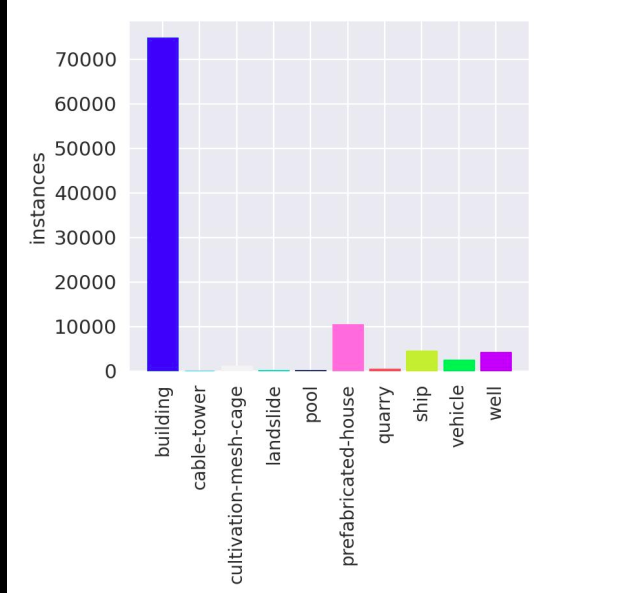  

#### Как видно из графика в датасете  больше всего зданий класс 0, нужно увеличить количество других классов  
увеличим колличество классов аугментируя изображения  где есть классы кроме 0!

## Увеличение датасета  
##  Аугментация  2.
#### выберем данные где обязательно есть классы кроме 0 и 5

In [ ]:
# Фильтрация изображений, выбор изображений где есть другие классы кроме 0 и 5.
import os
import shutil

def filter_and_copy_files(images_dir, annotations_dir, output_images_dir, output_annotations_dir):
    os.makedirs(output_images_dir, exist_ok=True)
    os.makedirs(output_annotations_dir, exist_ok=True)
    
    count = 0
    for annotation_file in os.listdir(annotations_dir):
        annotation_path = os.path.join(annotations_dir, annotation_file)
        
        with open(annotation_path, 'r') as f:
            lines = f.readlines()
            
        # Проверяем, есть ли классы, не  0 и 5
        contains_other_classes = any(line.split()[0] not in {'0', '5'} for line in lines)
        
        if contains_other_classes:
            image_file = annotation_file.replace('.txt', '.jpg')  
            image_path = os.path.join(images_dir, image_file)
            
            if os.path.exists(image_path):
                shutil.copy(annotation_path, os.path.join(output_annotations_dir, annotation_file))
                shutil.copy(image_path, os.path.join(output_images_dir, image_file))
                count += 1
    print(f"Изображения скопированы, всего: {count}")


# Пути к датасету
image_1 = 'dataset_UAVOD/datasets_split/images/train/'   
images_dir = os.path.join(path_dataset, image_1)  
labels_1 = 'dataset_UAVOD/datasets_split/labels/train/'   
annotations_dir = os.path.join(path_dataset, labels_1) 

image_2 = 'dataset_UAVOD/datasets_split/images/train_filter/'   
output_images_dir = os.path.join(path_dataset, image_2)  
labels_2 = 'dataset_UAVOD/datasets_split/labels/train_filter/'   
output_annotations_dir = os.path.join(path_dataset, labels_2)  


# Запускаем фильтрацию
# filter_and_copy_files(images_dir, annotations_dir, output_images_dir, output_annotations_dir)


In [ ]:
import os
import cv2
import numpy as np

def read_yolo_labels(label_path):
    boxes = []
    with open(label_path, 'r') as f:
        for line in f.readlines():
            parts = line.strip().split()
            cls = int(parts[0])
            cx, cy, bw, bh = map(float, parts[1:])
            boxes.append([cls, cx, cy, bw, bh])
    return boxes


def save_yolo_labels(output_path, boxes):
    with open(output_path, 'w') as f:
        for box in boxes:
            cls, cx, cy, bw, bh = box
            f.write(f"{cls} {cx:.6f} {cy:.6f} {bw:.6f} {bh:.6f}\n")


def convert_box_to_crop_coords(box, w, h):
    cls, cx, cy, bw, bh = box
    x = cx * w
    y = cy * h
    return int(x), int(y)


def generate_object_focus_crops(image_path, label_path, output_img_dir, output_lbl_dir,
                                crop_size=1200, step=50, exclude_classes=[0, 5]):
    """ 
        Вырезает из большого изображения окна размером crop_size с шагом step.
    """
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    h, w = image.shape[:2]

    boxes = read_yolo_labels(label_path)

    if not boxes:
        return
    

    
    if w < crop_size or h < crop_size:  # Пропускаем обработку маленького изображения
        print(f"Изображение {image_path} слишком маленькое (ширина: {w}, высота: {h}). Пропускаем.")
        return  


    base_name = os.path.splitext(os.path.basename(image_path))[0]
    crop_id = 0
    used_windows = []

    for box in boxes:
        cls, cx, cy, bw, bh = box
        if cls in exclude_classes:
            continue

        x_center, y_center = convert_box_to_crop_coords(box, w, h)

        for dx in [-step, 0, step]:
            for dy in [-step, 0, step]:
                new_cx = x_center + dx
                new_cy = y_center + dy

                x_start = int(min(max(new_cx - crop_size // 2, 0), w - crop_size))
                y_start = int(min(max(new_cy - crop_size // 2, 0), h - crop_size))

                is_similar = any(abs(x_start - ux) < step and abs(y_start - uy) < step for ux, uy in used_windows)
                if is_similar:
                    continue

                used_windows.append((x_start, y_start))

                x_end = x_start + crop_size
                y_end = y_start + crop_size

                cropped_image = image[y_start:y_end, x_start:x_end]

                crop_boxes = []
                for b in boxes:
                    b_cls, b_cx, b_cy, b_bw, b_bh = b
                    abs_cx = b_cx * w
                    abs_cy = b_cy * h
                    abs_bw = b_bw * w
                    abs_bh = b_bh * h

                    box_x1 = abs_cx - abs_bw / 2
                    box_y1 = abs_cy - abs_bh / 2
                    box_x2 = abs_cx + abs_bw / 2
                    box_y2 = abs_cy + abs_bh / 2

                    if (box_x2 < x_start or box_x1 > x_end or
                        box_y2 < y_start or box_y1 > y_end):
                        continue

                    new_x1 = max(box_x1, x_start)
                    new_y1 = max(box_y1, y_start)
                    new_x2 = min(box_x2, x_end)
                    new_y2 = min(box_y2, y_end)

                    new_cx = ((new_x1 + new_x2) / 2 - x_start) / crop_size
                    new_cy = ((new_y1 + new_y2) / 2 - y_start) / crop_size
                    new_bw = (new_x2 - new_x1) / crop_size
                    new_bh = (new_y2 - new_y1) / crop_size

                    if new_bw <= 0 or new_bh <= 0:
                        continue

                    crop_boxes.append([b_cls, new_cx, new_cy, new_bw, new_bh])

                if not any(b[0] not in exclude_classes for b in crop_boxes):
                    continue

                out_img_path = os.path.join(output_img_dir, f"{base_name}_crop{crop_id}.jpg")
                out_lbl_path = os.path.join(output_lbl_dir, f"{base_name}_crop{crop_id}.txt")

                #  Ресайз изображения с минимальной стороной 
                aug_img_resized = resize_with_min_side(cropped_image, min_side=1024)


                cv2.imwrite(out_img_path, cv2.cvtColor(aug_img_resized, cv2.COLOR_RGB2BGR))
                save_yolo_labels(out_lbl_path, crop_boxes)
                crop_id += 1



def generate_crops_for_dataset(image_dir, label_dir, output_img_dir, output_lbl_dir,
                               crop_size=1200, step=50, exclude_classes=[0, 5]):
    os.makedirs(output_img_dir, exist_ok=True)
    os.makedirs(output_lbl_dir, exist_ok=True)

    image_paths = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith(".jpg")]
    label_paths = [os.path.join(label_dir, f.replace(".jpg", ".txt")) for f in os.listdir(image_dir) if f.endswith(".jpg")]

    for image_path, label_path in zip(image_paths, label_paths):
        generate_object_focus_crops(image_path, label_path, output_img_dir, output_lbl_dir,
                                    crop_size=crop_size, step=step, exclude_classes=exclude_classes)

    print(f"Обработка завершена! Все вырезки сохранены в {output_img_dir} и {output_lbl_dir}.")



dataset = 3


# Пути к датасету
if dataset == 0:
    image_1 = 'dataset_UAVOD/datasets_split/images/train_filter/'    
    input_images_dir = os.path.join(path_dataset, image_1)  
    labels_1 = 'dataset_UAVOD/datasets_split/labels/train_filter/'  
    input_labels_dir = os.path.join(path_dataset, labels_1) 
    
    image_2 = 'dataset_UAVOD/datasets_split/images/train_augment_filter_2/'   
    output_images_dir = os.path.join(path_dataset, image_2)  
    labels_2 = 'dataset_UAVOD/datasets_split/labels/train_augment_filter_2/'   
    output_labels_dir = os.path.join(path_dataset, labels_2)  
elif dataset == 1:
    image_1 = 'dataset_UAVOD/datasets_split/images/val/'    
    input_images_dir = os.path.join(path_dataset, image_1)  
    labels_1 = 'dataset_UAVOD/datasets_split/labels/val/'  
    input_labels_dir = os.path.join(path_dataset, labels_1) 
    
    image_2 = 'dataset_UAVOD/datasets_split/images/val_augment_1/'   
    output_images_dir = os.path.join(path_dataset, image_2)  
    labels_2 = 'dataset_UAVOD/datasets_split/labels/val_augment_1/'   
    output_labels_dir = os.path.join(path_dataset, labels_2)  
elif dataset == 2:
    image_1 = 'dataset_UAVOD/datasets_split/images/test/'    
    input_images_dir = os.path.join(path_dataset, image_1)  
    labels_1 = 'dataset_UAVOD/datasets_split/labels/test/'  
    input_labels_dir = os.path.join(path_dataset, labels_1) 
    
    image_2 = 'dataset_UAVOD/datasets_split/images/test_augment_1/'   
    output_images_dir = os.path.join(path_dataset, image_2)  
    labels_2 = 'dataset_UAVOD/datasets_split/labels/test_augment_1/'   
    output_labels_dir = os.path.join(path_dataset, labels_2)  
elif dataset == 3:
    image_1 = 'dataset_UAVOD/dota/images/'    
    input_images_dir = os.path.join(path_dataset, image_1)  
    labels_1 = 'dataset_UAVOD/dota/target/'  
    input_labels_dir = os.path.join(path_dataset, labels_1) 
    
    image_2 = 'dataset_UAVOD/datasets_split/images/train_augment_dota_1/'   
    output_images_dir = os.path.join(path_dataset, image_2)  
    labels_2 = 'dataset_UAVOD/datasets_split/labels/train_augment_dota_1/'   
    output_labels_dir = os.path.join(path_dataset, labels_2)  



def aug_2():
    generate_crops_for_dataset(
        image_dir=input_images_dir,  
        label_dir=input_labels_dir, 
        output_img_dir=output_images_dir,  
        output_lbl_dir=output_labels_dir, 
        crop_size=1024,         # Размер вырезки
        step=200,                # Шаг для сдвигов окна
        exclude_classes=[0, 5]  # Исключенные классы
    )

# aug_2()


## Аугментация 3.  

преобразование исходных (больших) отфильтрованных изображений 

In [ ]:
import os
import cv2
import numpy as np
from glob import glob

# # Пути к датасету train
# image_1 = 'dataset_UAVOD/datasets_split/images/train_filter/'    
# input_images_dir = os.path.join(path_dataset, image_1)  
# labels_1 = 'dataset_UAVOD/datasets_split/labels/train_filter/'  
# input_labels_dir = os.path.join(path_dataset, labels_1) 
 
# image_2 = 'dataset_UAVOD/datasets_split/images/train_augment_3/'   
# output_images_dir = os.path.join(path_dataset, image_2)  
# labels_2 = 'dataset_UAVOD/datasets_split/labels/train_augment_3/'   
# output_labels_dir = os.path.join(path_dataset, labels_2)  


# # Пути к датасету val 
# image_1 = 'dataset_UAVOD/datasets_split/images/val/'    
# input_images_dir = os.path.join(path_dataset, image_1)  
# labels_1 = 'dataset_UAVOD/datasets_split/labels/val/'  
# input_labels_dir = os.path.join(path_dataset, labels_1) 
 
# image_2 = 'dataset_UAVOD/datasets_split/images/val_augment_3/'   
# output_images_dir = os.path.join(path_dataset, image_2)  
# labels_2 = 'dataset_UAVOD/datasets_split/labels/val_augment_3/'   
# output_labels_dir = os.path.join(path_dataset, labels_2)  

# Пути к датасету  test
image_1 = 'dataset_UAVOD/datasets_split/images/test/'    
input_images_dir = os.path.join(path_dataset, image_1)  
labels_1 = 'dataset_UAVOD/datasets_split/labels/test/'  
input_labels_dir = os.path.join(path_dataset, labels_1) 
 
image_2 = 'dataset_UAVOD/datasets_split/images/test_augment_2/'   
output_images_dir = os.path.join(path_dataset, image_2)  
labels_2 = 'dataset_UAVOD/datasets_split/labels/test_augment_2/'   
output_labels_dir = os.path.join(path_dataset, labels_2)  




def augment_images(input_images_dir, input_labels_dir, output_images_dir, output_labels_dir):

    # Создаем  папки выхода 
    os.makedirs(output_images_dir, exist_ok=True)
    os.makedirs(output_labels_dir, exist_ok=True)


    def clip_bbox(bboxes):
        """Ограничивает координаты bbox в диапазоне [0,1]"""
        clipped_bboxes = []
        for box in bboxes:
            class_id, x, y, w, h = box
            x = max(0, min(1, x))
            y = max(0, min(1, y))
            w = max(0, min(1, w))
            h = max(0, min(1, h))
            clipped_bboxes.append([class_id, x, y, w, h])
        return clipped_bboxes


    def adjust_brightness(image, bboxes, factor=0.8, scale_factor = 0.9):
        """Изменение яркости изображения"""
        scaled_img, scaled_boxes  = scale_image(image, bboxes, scale_factor=scale_factor)


        return np.clip(scaled_img * factor, 0, 255).astype(np.uint8), scaled_boxes


    def add_noise(image, mean=0, std=25):
        """Добавление случайного  шума"""
        noise = np.random.normal(mean, std, image.shape).astype(np.int16)  
        noisy_image = np.clip(image.astype(np.int16) + noise, 0, 255) 
        return noisy_image.astype(np.uint8)



    def flip_image(image, bboxes, flip_code):
        """Отражение изображения и корректировка аннотаций"""
        h, w = image.shape[:2]
        flipped_img = cv2.flip(image, flip_code)
        
        new_bboxes = []
        for box in bboxes:
            class_id, x, y, bw, bh = box
            if flip_code == 1:  # Горизонтальное отражение
                x = 1 - x
            elif flip_code == 0:  # Вертикальное отражение
                y = 1 - y
            new_bboxes.append([class_id, x, y, bw, bh])
        
        return flipped_img, new_bboxes


    def scale_image(image, bboxes, scale_factor):
        """Масштабирование изображения."""
        h, w = image.shape[:2]
        new_h, new_w = int(h * scale_factor), int(w * scale_factor)

        # Масштабируем изображение
        resized_img = cv2.resize(image, (new_w, new_h))

        if scale_factor > 1:
            # Увеличение -> Обрезка центра
            crop_x = (new_w - w) // 2
            crop_y = (new_h - h) // 2
            final_img = resized_img[crop_y:crop_y + h, crop_x:crop_x + w]

            # Корректируем YOLO боксы (центр + размер)
            new_bboxes = []
            for class_id, x, y, bw, bh in bboxes:
                abs_x = x * new_w  # Денормализация в пиксели
                abs_y = y * new_h
                abs_bw = bw * new_w
                abs_bh = bh * new_h
                
                # Смещаем координаты в новую систему
                new_x = (abs_x - crop_x) / w
                new_y = (abs_y - crop_y) / h
                new_bw = abs_bw / w
                new_bh = abs_bh / h

                # Проверяем, не выходит ли бокс за границы
                if 0 <= new_x <= 1 and 0 <= new_y <= 1:
                    new_bboxes.append([class_id, new_x, new_y, new_bw, new_bh])

        else:
            # Уменьшение -> Паддинг (по центру)
            pad_x = (w - new_w) // 2
            pad_y = (h - new_h) // 2
            final_img = np.zeros((h, w, 3), dtype=np.uint8)
            final_img[pad_y:pad_y + new_h, pad_x:pad_x + new_w] = resized_img

            # Корректируем YOLO боксы (центр + размер)
            new_bboxes = []
            for class_id, x, y, bw, bh in bboxes:
                abs_x = x * new_w
                abs_y = y * new_h
                abs_bw = bw * new_w
                abs_bh = bh * new_h

                new_x = (abs_x + pad_x) / w
                new_y = (abs_y + pad_y) / h
                new_bw = abs_bw / w
                new_bh = abs_bh / h

                new_bboxes.append([class_id, new_x, new_y, new_bw, new_bh])

        return final_img, new_bboxes


    image_paths = glob(os.path.join(input_images_dir, "*.jpg"))

    for image_path in image_paths:
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Загружаем аннотации 
        label_path = os.path.join(input_labels_dir, os.path.basename(image_path).replace(".jpg", ".txt"))
        
        if not os.path.exists(label_path):
            continue  
        
        with open(label_path, "r") as f:
            lines = f.readlines()
        
        bboxes = []
        for line in lines:
            values = line.split()
            class_id = int(values[0])
            x, y, w, h = map(float, values[1:])
            bboxes.append([class_id, x, y, w, h])
        
        augmented_images = []
        augmented_bboxes = []

        # 0 Горизонтальный флип
        flipped_img, flipped_boxes = flip_image(img, bboxes, flip_code=1)
        augmented_images.append(flipped_img)
        augmented_bboxes.append(flipped_boxes)

        # 1 Вертикальный флип
        flipped_img, flipped_boxes = flip_image(img, bboxes, flip_code=0)
        augmented_images.append(flipped_img)
        augmented_bboxes.append(flipped_boxes)

        # 2  Масштабирование
        scaled_img1, scaled_boxes1 = scale_image(img, bboxes, scale_factor=1.1)
        augmented_images.append(scaled_img1)
        augmented_bboxes.append(scaled_boxes1)

        #  3 Горизонтальный флип c масштабированием
        flipped_img1, flipped_boxes1 = flip_image(scaled_img1, scaled_boxes1, flip_code=1)
        augmented_images.append(flipped_img1)
        augmented_bboxes.append(flipped_boxes1)

        # 4 Вертикальный флип с масштабированием
        flipped_img2, flipped_boxes2 = flip_image(scaled_img1, scaled_boxes1, flip_code=0)
        augmented_images.append(flipped_img2)
        augmented_bboxes.append(flipped_boxes2)

        # # 5 Яркость
        # bright_img, adjust_bboxes = adjust_brightness(flipped_img1, flipped_boxes1, factor=1.1, scale_factor=0.9)
        # augmented_images.append(bright_img)
        # augmented_bboxes.append(adjust_bboxes)

        # # 6 Яркость
        # bright_img, adjust_bboxes = adjust_brightness(flipped_img2, flipped_boxes2, factor=0.9, scale_factor=0.9)
        # augmented_images.append(bright_img)
        # augmented_bboxes.append(adjust_bboxes)


        # # 7 Яркость
        # bright_img, adjust_bboxes = adjust_brightness(img, bboxes, factor=0.9, scale_factor=1.1)
        # augmented_images.append(bright_img)
        # augmented_bboxes.append(adjust_bboxes)

        # # 8 Яркость
        # bright_img, adjust_bboxes = adjust_brightness(img, bboxes, factor=1.1, scale_factor=1.1)
        # augmented_images.append(bright_img)
        # augmented_bboxes.append(adjust_bboxes)

        # # 9 Шум
        # noisy_img = add_noise(bright_img)
        # augmented_images.append(noisy_img)
        # augmented_bboxes.append(adjust_bboxes)


        # 10 Масштабирование
        scaled_img, scaled_boxes = scale_image(img, bboxes, scale_factor=1.1)
        augmented_images.append(scaled_img)
        augmented_bboxes.append(scaled_boxes)


        # 11  Масштабирование
        scaled_img2, scaled_boxes2 = scale_image(img, bboxes, scale_factor=0.9)
        augmented_images.append(scaled_img2)
        augmented_bboxes.append(scaled_boxes2)

        # Сохраняем аугментированные изображения и аннотации
        for i, (aug_img, aug_boxes) in enumerate(zip(augmented_images, augmented_bboxes)):
            aug_boxes = clip_bbox(aug_boxes) 
            output_image_path = os.path.join(output_images_dir, f"{os.path.basename(image_path).replace('.jpg', '')}_aug1_new{i}.jpg")
            #  Ресайз изображения с минимальной стороной 
            aug_img_resized = resize_with_min_side(aug_img, min_side=1024)          
            cv2.imwrite(output_image_path, cv2.cvtColor(aug_img_resized, cv2.COLOR_RGB2BGR))
            
            output_label_path = os.path.join(output_labels_dir, f"{os.path.basename(label_path).replace('.txt', '')}_aug1_new{i}.txt")
            with open(output_label_path, "w") as f:
                for bbox in aug_boxes:
                    f.write(f"{bbox[0]} {bbox[1]} {bbox[2]} {bbox[3]} {bbox[4]}\n")


    print("Аугментированный датасет сохранён!")

def aug_3():
    augment_images(input_images_dir, input_labels_dir, output_images_dir, output_labels_dir)

# aug_3()

In [23]:
import glob


labels_1 = 'dataset_UAVOD/datasets_original/target_yolo/'  
labels_path = os.path.join(path_dataset, labels_1) 
 


label_paths = glob.glob(f"{labels_path}*.txt")
class_counts = {}

for label_path in label_paths:
    with open(label_path, "r") as file:
        lines = file.readlines()
    
    for line in lines:
        parts = line.split()
        if parts:  # Если строка не пустая
            class_id = int(parts[0])  # Получаем class_id
            class_counts[class_id] = class_counts.get(class_id, 0) + 1  # Считаем

print("Количество объектов по классам:")
# Вывод всех классов и их количества
for class_id, count in sorted(class_counts.items()):
    print(f"Класс {class_id}: {count} объектов")

Количество объектов по классам:
Класс 0: 12662 объектов
Класс 2: 263 объектов
Класс 3: 40 объектов
Класс 4: 49 объектов
Класс 5: 2027 объектов
Класс 6: 83 объектов
Класс 7: 771 объектов
Класс 8: 466 объектов
Класс 9: 677 объектов


### Баланс классов



  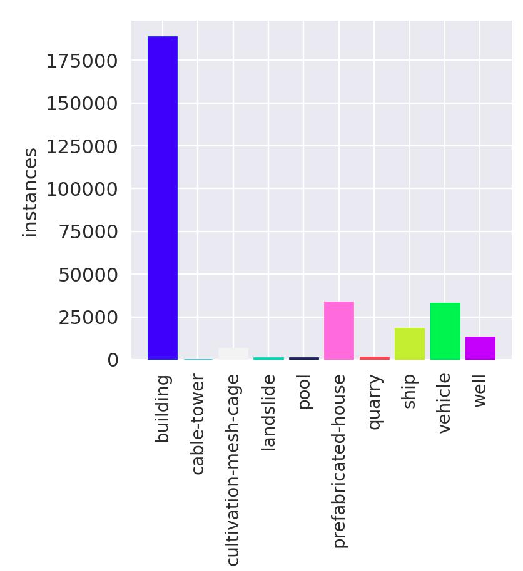


__Количество классов увеличилось, но увеличилось количество класса 0__   

нужно аугментировать датасет на изображениях где нет классов 0 и 5!

### Как можно видеть, хуже всего обрабатываются  классы vehicle, pool  и  landslide  

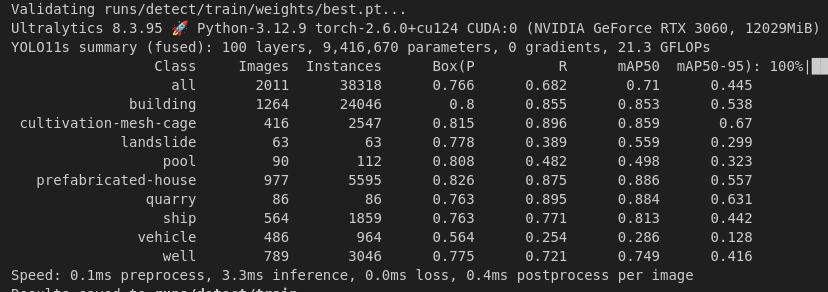  

несмотря на увеличение класса  автомобиль всё равно плохо детектируется и распознаётся  

###  Разнообразили датасет изображениями с датасета DOTA.
Лишние классы были удалены  и размечен класс зданий и пропущенные объекты других классов  




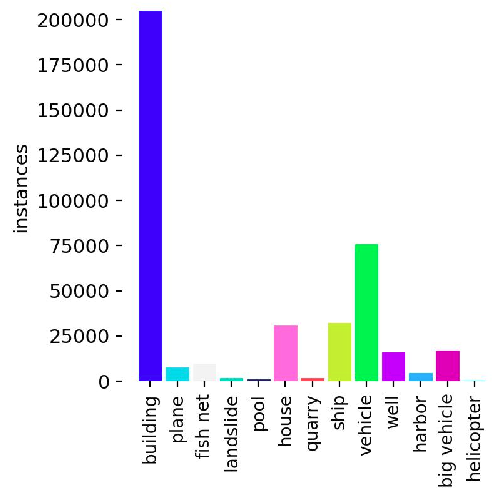

## 2. ДАТАСЕТ DOTA

#### Конвертация аннотаций формата DOTA в YOLO

In [ ]:
import os
import xml.etree.ElementTree as ET

# Получаем текущую рабочую папку  
current_directory = os.getcwd()  

path_dataset = os.path.join(current_directory, "dataset")

 
labels_1 = 'dataset_DOTA/dataset_DOTA/lables/'  
dota_labels_path = os.path.join(path_dataset, labels_1) 

In [ ]:
import glob

label_paths = glob.glob(f"{dota_labels_path}*.txt")       # путь к аннотациям DOTA
class_names = set()

for label_path in label_paths:
    with open(label_path, "r") as file:
        lines = file.readlines()
    
    for line in lines:
        parts = line.strip().split()
        if len(parts) > 8:                               # Проверяем, есть ли название класса (оно 9-й элемент)
            class_name = parts[-2]                       # В DOTA имя класса идет перед difficulty
            class_names.add(class_name)

print("Классы датасета:")
print("Найденные классы в DOTA:", class_names)


Классы датасета:
Найденные классы в DOTA: {'swimming-pool', 'small-vehicle', 'container-crane', 'helicopter', 'ground-track-field', 'basketball-court', 'plane', 'harbor', 'ship', 'baseball-diamond', 'tennis-court', 'storage-tank', 'roundabout', 'soccer-ball-field', 'large-vehicle', 'bridge'}




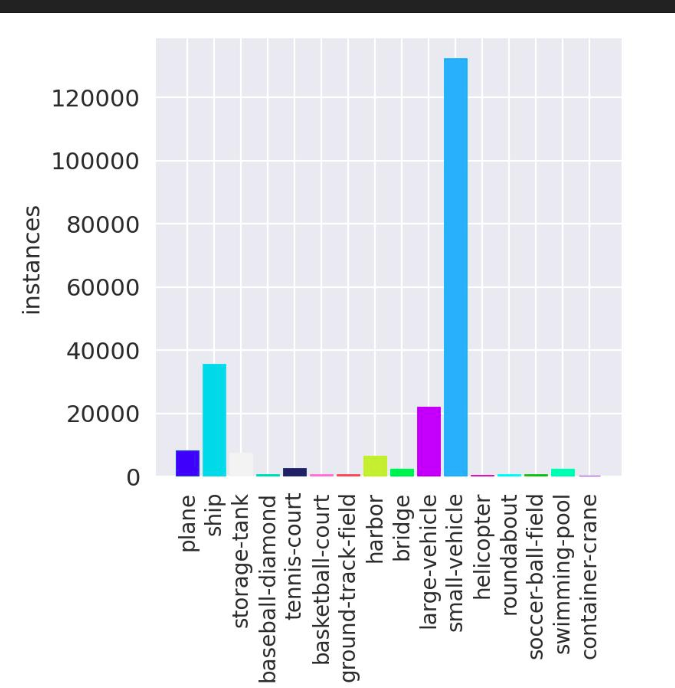

In [ ]:
# Конвертация в формат yolo
import os
import cv2

# Пути к файлам

image_2 = 'dataset_DOTA/dataset_DOTA/images/'   
images_path = os.path.join(path_dataset, image_2)  
labels_2 = 'dataset_DOTA/dataset_DOTA/yolo_labels/'   
yolo_labels_path = os.path.join(path_dataset, labels_2)  


os.makedirs(yolo_labels_path, exist_ok=True)

# Словарь классов DOTA  в YOLO 
dota_classes = {
    "plane": 0, "ship": 1, "storage-tank": 2, "baseball-diamond": 3, "tennis-court": 4,
    "basketball-court": 5, "ground-track-field": 6, "harbor": 7, "bridge": 8,
    "large-vehicle": 9, "small-vehicle": 10, "helicopter": 11, "roundabout": 12,
    "soccer-ball-field": 13, "swimming-pool": 14, "container-crane": 15
}

# Функция для конвертации аннотации
def convert_dota_to_yolo(dota_file, yolo_file, img_file):
    image = cv2.imread(img_file)
    if image is None:
        print(f"Ошибка: Не удалось загрузить изображение {img_file}")
        return
    
    img_h, img_w, _ = image.shape  #  высота ширина каналы

    with open(dota_file, "r") as f:
        lines = f.readlines()

    yolo_annotations = []

    for line in lines:
        parts = line.strip().split()
        if len(parts) < 9:        # Проверяем корректность строки
            continue

        # Читаем координаты 4 точек
        x1, y1, x2, y2, x3, y3, x4, y4 = map(float, parts[:8])
        class_name = parts[8]

        # Пропускаем неизвестные классы
        if class_name not in dota_classes:
            continue

        # YOLO-класс
        class_id = dota_classes[class_name]

        # Находим центр  бокса
        x_min = min(x1, x2, x3, x4)
        x_max = max(x1, x2, x3, x4)
        y_min = min(y1, y2, y3, y4)
        y_max = max(y1, y2, y3, y4)

        x_center = (x_min + x_max) / 2.0
        y_center = (y_min + y_max) / 2.0
        box_width = x_max - x_min
        box_height = y_max - y_min

        # Нормализация 
        x_center /= img_w
        y_center /= img_h
        box_width /= img_w
        box_height /= img_h

        # Проверка на корректность размеров
        if box_width <= 0 or box_height <= 0:
            continue


        yolo_annotations.append(f"{class_id} {x_center:.6f} {y_center:.6f} {box_width:.6f} {box_height:.6f}\n")

    # Записываем  если есть боксы
    if yolo_annotations:
        with open(yolo_file, "w") as f:
            f.writelines(yolo_annotations)

def convert_to_yolo():
    for dota_file in os.listdir(dota_labels_path):
        if dota_file.endswith(".txt"):
            # Имя файла
            file_name = os.path.splitext(dota_file)[0]
            dota_file_path = os.path.join(dota_labels_path, dota_file)
            yolo_file_path = os.path.join(yolo_labels_path, dota_file)
            img_file_path = os.path.join(images_path, file_name + ".png")
            # Проверяем, существует ли изображение
            if not os.path.exists(img_file_path):
                print(f"Пропуск: Нет изображения для {dota_file}")
                continue
            # Конвертация
            convert_dota_to_yolo(dota_file_path, yolo_file_path, img_file_path)

    print("Конвертация завершена!")
# convert_to_yolo()

### Проверка  и исправление аннотаций

In [ ]:
import os
import glob


image_2 = 'dataset_DOTA/dataset_DOTA/images/'   
image_dir = os.path.join(path_dataset, image_2)  
labels_2 = 'dataset_DOTA/dataset_DOTA/yolo_labels/'   
labels_dir = os.path.join(path_dataset, labels_2)  


def normalize_annotations():
    label_files = glob.glob(os.path.join(labels_dir, "*.txt"))

    for label_file in label_files:
        with open(label_file, "r") as f:
            lines = f.readlines()

        new_lines = []
        has_errors = False

        for line in lines:
            parts = line.strip().split()
            if len(parts) < 5:
                continue  

            class_id, x, y, w, h = map(float, parts[:5])

            # Проверяем координаты
            if x > 1 or y > 1 or w > 1 or h > 1:
                has_errors = True
                x, y, w, h = min(x, 1), min(y, 1), min(w, 1), min(h, 1)

            new_lines.append(f"{int(class_id)} {x:.6f} {y:.6f} {w:.6f} {h:.6f}\n")

        # Если были ошибки перезаписываем 
        if has_errors:
            with open(label_file, "w") as f:
                f.writelines(new_lines)
            print(f"Исправлено: {label_file}")
    print("Готово! Ошибки в аннотациях исправлены.")

# normalize_annotations()



Готово! Ошибки в аннотациях исправлены.


### Количество объектов по классам

In [ ]:
import glob

labels_1 = 'dataset_DOTA/dataset_DOTA/yolo_labels/'  
dota_labels_path = os.path.join(path_dataset, labels_1) 
 


label_paths = glob.glob(f"{dota_labels_path}*.txt")
class_counts = {}

for label_path in label_paths:
    with open(label_path, "r") as file:
        lines = file.readlines()
    
    for line in lines:
        parts = line.split()
        if parts:                                   # Если строка не пустая
            class_id = int(parts[0])                # Получаем class_id
            class_counts[class_id] = class_counts.get(class_id, 0) + 1  # Считаем

print("Количество объектов по классам:")
# Вывод всех классов и их количества
for class_id, count in sorted(class_counts.items()):
    print(f"Класс {class_id}: {count} объектов")

Количество объектов по классам:
Класс 0: 10622 объектов
Класс 1: 43738 объектов
Класс 2: 8286 объектов
Класс 3: 625 объектов
Класс 4: 3188 объектов
Класс 5: 672 объектов
Класс 6: 476 объектов
Класс 7: 8118 объектов
Класс 8: 2541 объектов
Класс 9: 27357 объектов
Класс 10: 169838 объектов
Класс 11: 713 объектов
Класс 12: 622 объектов
Класс 13: 487 объектов
Класс 14: 2757 объектов
Класс 15: 156 объектов


### конвертируем в jpeg  и сжимаем изображения

In [29]:
import os
import glob
from PIL import Image

def convert_gpg1():
    image_2 = 'dataset_DOTA/dataset_DOTA/images/'   
    input_folder = os.path.join(path_dataset, image_2)  
    labels_2 = 'dataset_DOTA/dataset_DOTA/yolo_labels/'   
    labels_dir = os.path.join(path_dataset, labels_2)  
    image_3 = 'dataset_DOTA/dataset_DOTA/images_jpeg/'   
    output_folder = os.path.join(path_dataset, image_3)  


    os.makedirs(output_folder, exist_ok=True)

    image_paths = glob.glob(os.path.join(input_folder, "*.png"))

    for img_path in image_paths:
        img = Image.open(img_path).convert("RGB")  # Убираем прозрачность

        output_path = os.path.join(output_folder, os.path.basename(img_path).replace(".png", ".jpg"))
        img.save(output_path, "JPEG", quality=99)  # качество 

    print("PNG успешно конвертированы в JPEG!")

# convert_gpg1()()

### изменение разметки датасета DOTA  для датасета UAVOD

In [ ]:
"""
    Изменяем разметку  DOTA  для UAVOD для дальейшего объединения
    убираем лишние классы. и переименонвываем классы
"""


import os
from glob import glob
def cleaned1():
    input_dir = "/home/maksim/develops/python/devsTraining/zala_task/dataset/dataset_DOTA/dataset_DOTA/yolo_labels/"
    output_dir = "cleaned_labels"
    os.makedirs(output_dir, exist_ok=True)

    # ===============    Словарь  классов для переименования
    class_map = {
        0: 1,
        1: 7,
        7: 10,
        9: 11,
        10: 8,
        11: 12
    }

    # =======================     Классы, которые удаляем 
    remove_classes = {2, 3, 4, 5, 6, 8, 12, 13, 14, 15}

    # ======================       Обработка всех .txt файлов 
    label_files = glob(os.path.join(input_dir, "*.txt"))
    print(f"Найдено {len(label_files)} файлов для обработки.")

    for path in label_files:
        with open(path, "r") as f:
            lines = f.readlines()

        new_lines = []
        for line in lines:
            parts = line.strip().split()
            if len(parts) != 5:
                continue

            class_id = int(parts[0])
            if class_id in remove_classes:
                continue
            elif class_id in class_map:
                parts[0] = str(class_map[class_id])
                new_lines.append(" ".join(parts))
            else:
                new_lines.append(" ".join(parts)) 

        filename = os.path.basename(path)
        output_path = os.path.join(output_dir, filename)
        with open(output_path, "w") as f:
            f.write("\n".join(new_lines) + "\n")

        print(f"✔ Сохранён: {output_path}")

    print("Готово: все обновлённые разметки сохранены в cleaned_labels/")
# cleaned1()

## 3. Обработка датасета для custom_yolo

### удаление лишних классов
Были обработаны данные из датасетов UAVOD и DOTA  
Сохранены в разные каталоги для обучения моделей по отдельности и вместе  

In [ ]:
# фильтрует классы удаляет лишние
import os
import shutil

def filter_yolo_dataset(
    img_dir="/home/maksim/develops/python/devsTraining/zala_task/dataset/dataset_UAVOD/dota/images/",
    label_dir="/home/maksim/develops/python/devsTraining/zala_task/dataset/dataset_UAVOD/dota/target/",
    output_img_dir="filtered_images",
    output_label_dir="filtered_targets"
):
    os.makedirs(output_img_dir, exist_ok=True)
    os.makedirs(output_label_dir, exist_ok=True)

    # Классы для фильтрации и замены (Нужны три класса)
    allowed_classes = {8: 3, 7: 2, 1: 1}

    for label_file in os.listdir(label_dir):
        if not label_file.endswith(".txt"):
            continue

        label_path = os.path.join(label_dir, label_file)
        with open(label_path, "r") as f:
            lines = f.readlines()

        new_lines = []
        for line in lines:
            parts = line.strip().split()
            if not parts:
                continue

            class_id = int(parts[0])
            if class_id in allowed_classes:
                new_class_id = allowed_classes[class_id]
                new_line = " ".join([str(new_class_id)] + parts[1:])
                new_lines.append(new_line)

        # Сохраняем только если остались подходящие аннотации
        if new_lines:
            # Сохраняем отфильтрованные аннотации
            new_label_path = os.path.join(output_label_dir, label_file)
            with open(new_label_path, "w") as f:
                f.write("\n".join(new_lines) + "\n")

            # Копируем соответствующее изображение
            img_name = os.path.splitext(label_file)[0] + ".jpg"
            img_path = os.path.join(img_dir, img_name)
            out_img_path = os.path.join(output_img_dir, img_name)

            if os.path.exists(img_path):
                shutil.copy(img_path, out_img_path)


In [ ]:
img_dir="/home/maksim/develops/python/devsTraining/zala_task/dataset/dataset_UAVOD/dota/images/"
label_dir="/home/maksim/develops/python/devsTraining/zala_task/dataset/dataset_UAVOD/dota/target/"

# filter_yolo_dataset(img_dir=img_dir, label_dir=label_dir, output_img_dir="filtered_images", output_label_dir="filtered_targets")


### Объеденяем все классы

In [ ]:
# Все три класса объеденим в один. Для упрощения детекции.
import os
def replacing_annotations():
    input_folder = "/home/maksim/develops/python/devsTraining/zala_task/dataset/dataset_mobileNet/dataset_5/target/"       
    output_folder = "target_fixed"  

    os.makedirs(output_folder, exist_ok=True)

    for filename in os.listdir(input_folder):
        if filename.endswith(".txt"):
            input_path = os.path.join(input_folder, filename)
            output_path = os.path.join(output_folder, filename)

            with open(input_path, "r") as f:
                lines = f.readlines()

            new_lines = []
            for line in lines:
                parts = line.strip().split()
                if len(parts) >= 5:
                    parts[0] = "1"  # заменяем класс на 1
                    new_lines.append(" ".join(parts))

            # Сохраняем в новую папку
            with open(output_path, "w") as f:
                for line in new_lines:
                    f.write(line + "\n")

    print("Все классы заменены на 1 и сохранены в папку target_fixed/")

# replacing_annotations()

Все классы заменены на 1 и сохранены в папку target_fixed/


### Уменьшаем изображения (делаем квадратными)

In [ ]:
# Получаем текущую рабочую папку  
current_directory = os.getcwd()  

path_dataset = os.path.join(current_directory, "dataset")
image_1 = 'dataset_mobileNet/dataset_3/image/'    
input_images_dir = os.path.join(path_dataset, image_1)  
labels_1 = 'dataset_mobileNet/dataset_3/target_fixed/'  
input_labels_dir = os.path.join(path_dataset, labels_1) 

image_2 = 'dataset_mobileNet/dataset_7/image/'   
output_images_dir = os.path.join(path_dataset, image_2)  
labels_2 = 'dataset_mobileNet/dataset_7/target/'   
output_labels_dir = os.path.join(path_dataset, labels_2) 


def aug_5():
    generate_crops_for_dataset(
        image_dir=input_images_dir,  
        label_dir=input_labels_dir, 
        output_img_dir=output_images_dir,  
        output_lbl_dir=output_labels_dir, 
        crop_size=700,         # Размер вырезки
        step=200,                # Шаг для сдвигов окна
        exclude_classes=[0, 5]  # Исключенные классы
    )

aug_5()

Изображение /home/maksim/develops/python/devsTraining/zala_task/dataset/dataset_mobileNet/dataset_3/image/504.jpg слишком маленькое (ширина: 1018, высота: 566). Пропускаем.
Обработка завершена! Все вырезки сохранены в /home/maksim/develops/python/devsTraining/zala_task/dataset/dataset_mobileNet/dataset_7/image/ и /home/maksim/develops/python/devsTraining/zala_task/dataset/dataset_mobileNet/dataset_7/target/.
